In [ ]:
import torch
print(torch.__version__)

In [ ]:
import torchvision
print(torchvision.__version__)

In [ ]:
if torch.cuda.is_available():
    devID=torch.cuda.current_device()
    devID, torch.cuda.get_device_name(devID)
else:
    print("Torch Cuda not avaialbe")

In [ ]:
PATH ='data/'
!ls data

In [ ]:
import pandas as pd 
import numpy as np 
import json

#movies = pd.read_csv(PATH+'tmdb_5000_movies.csv')
#credits = pd.read_csv(PATH+'tmdb_5000_credits.csv')

In [ ]:
def load_tmdb_movies(path):
    df = pd.read_csv(path)
    df['release_date'] = pd.to_datetime(df['release_date']).apply(lambda x: x.date())
    json_columns = ['genres', 'keywords', 'production_countries', 'production_companies', 'spoken_languages']
    for column in json_columns:
        df[column] = df[column].apply(json.loads)  #needed to make json objects lists rahter than strings
    return df

def load_tmdb_credits(path):
    df = pd.read_csv(path)
    json_columns = ['cast', 'crew']
    for column in json_columns:
        df[column] = df[column].apply(json.loads)
    return df

In [ ]:
movies = load_tmdb_movies(PATH+'tmdb_5000_movies.csv')
credits = load_tmdb_credits(PATH+'tmdb_5000_credits.csv')

In [ ]:
movies.head().T

In [ ]:
credits.head()

In [ ]:
credits.columns = ['id','title2','cast','crew']
credits.head()

In [ ]:
df = movies.merge(credits,how='inner',on='id')
df.head()

In [ ]:
df.info()

In [ ]:
df.shape

In [ ]:
df.describe()

In [ ]:
def splitJsonToList(obj, column):
    fullDict = []
    for i in obj[column]:
    #    dictLine = json.loads(i)
        localDict = []
        for items in i:
            localDict.append(items['name'])
    #    print(localDict)
        fullDict.append(localDict)
    return fullDict

In [ ]:
# this would run if we didn't load csv files with json.load 
# fullDict = []
# for i in movies['genres']:
#     dictLine = json.loads(i)
#     localDict = []
#     for items in dictLine:
#         localDict.append(items['name'])
#     print(localDict)
#     fullDict.append(localDict)

In [ ]:
df['genres'][0]

In [ ]:
df['keywords'][0]

In [ ]:
df['production_companies'][0]

In [ ]:
df['production_countries'][0]

In [ ]:
df['spoken_languages'][0]

In [ ]:
df['cast'][0]

In [ ]:
df['crew'][0]

In [ ]:
df2 = df.copy()

In [ ]:
features = ['genres', 'cast', 'crew', 'keywords','production_companies', 'production_countries', 'spoken_languages']
for column in features:
    df2[column] = splitJsonToList(df2, column)

In [ ]:
#movies2['genres'] = splitJsonToList(movies2, 'genres')
#['id', 'budget', 'original_title', 'popularity', 'vote_average', 'vote_count']

In [ ]:
df2.head()

In [ ]:
n_movies=int(df2.id.nunique())
n_movies

In [ ]:
df2.info()

In [2]:
#from sklearn.model_selection import train_test_split
#train, test = train_test_split(df2, test_size=0.2)
# print(train.shape,test.shape)

In [3]:
# select only few relative columns
df_small = df[['id', 'budget', 'popularity', 'vote_average', 'vote_count']].copy()

NameError: name 'df' is not defined

In [ ]:
df_small.head()

In [ ]:
# check cardinality of some variables
df_small['vote_count'].value_counts()

In [ ]:
# we don't have to dead with nan filling, since all values valid
df_small.isnull().values.any()

In [ ]:
#df_small.T
df_small.head()

In [ ]:
# check cardinality of some variables
df_small['budget'].value_counts()

We need to instantiate an object of the TabularData class we created earlier. But before that, we need to label encode the categorical features. For this, we will be using sklearn.preprocessing.LabelEncoder. 

In [ ]:
categorical_features = ["id", "vote_average", "vote_count", "budget"]
output_feature = "popularity"

In [ ]:
from sklearn.preprocessing import LabelEncoder

label_encoders = {}
for cat_col in categorical_features:
        label_encoders[cat_col] = LabelEncoder()
        df_small[cat_col] = label_encoders[cat_col].fit_transform(df_small[cat_col])

In [ ]:
df_small.head()

In [ ]:
df_small.info()

In [ ]:
# splitting dataset into train and test
from sklearn.model_selection import train_test_split as cv
df_small, df_small_test = cv.train_test_split(df_small, test_size=0.25)

In [41]:
from torch.utils.data import Dataset, DataLoader


class TabularDataset(Dataset):
  def __init__(self, data, cat_cols=None, output_col=None):
    """
    Characterizes a Dataset for PyTorch

    Parameters
    ----------

    data: pandas data frame
      The data frame object for the input data. It must
      contain all the continuous, categorical and the
      output columns to be used.

    cat_cols: List of strings
      The names of the categorical columns in the data.
      These columns will be passed through the embedding
      layers in the model. These columns must be
      label encoded beforehand. 

    output_col: string
      The name of the output variable column in the data
      provided.
    """

    self.n = data.shape[0]

    if output_col:
      self.y = data[output_col].astype(np.float32).values.reshape(-1, 1)
    else:
      self.y =  np.zeros((self.n, 1))

    self.cat_cols = cat_cols if cat_cols else []
    self.cont_cols = [col for col in data.columns
                      if col not in self.cat_cols + [output_col]]

    if self.cont_cols:
      self.cont_X = data[self.cont_cols].astype(np.float32).values
    else:
      self.cont_X = np.zeros((self.n, 1))

    if self.cat_cols:
      self.cat_X = data[cat_cols].astype(np.int64).values
    else:
      self.cat_X =  np.zeros((self.n, 1))

  def __len__(self):
    """
    Denotes the total number of samples.
    """
    return self.n

  def __getitem__(self, idx):
    """
    Generates one sample of data.
    """
    return [self.y[idx], self.cont_X[idx], self.cat_X[idx]]

Let’s instantiate an object of the TabularDataset class. 

In [42]:
# Pytorch abstract class representing a Dataset.
#All other datasets should subclass it. All subclasses should override
#``__len__``, that provides the size of the dataset, and ``__getitem__``,

dataset = TabularDataset(data=df_small, cat_cols=categorical_features,
                             output_col=output_feature)

In [43]:
dataset.cat_cols,dataset.cat_X, dataset.cont_cols, dataset.cont_X, dataset.y, dataset.n

(['id', 'vote_average', 'vote_count', 'budget'],
 array([[2702,   54, 1606,  426],
        [ 131,   51, 1496,  434],
        [4313,   45, 1492,  427],
        ...,
        [4383,   52,    6,    0],
        [4082,   39,    7,    0],
        [2916,   45,   16,    0]]),
 [],
 array([[0.],
        [0.],
        [0.],
        ...,
        [0.],
        [0.],
        [0.]]),
 array([[150.43758 ],
        [139.08261 ],
        [107.376785],
        ...,
        [  1.444476],
        [  0.857008],
        [  1.929883]], dtype=float32),
 4803)

In [44]:
len(dataset.cont_cols)

0

In [45]:
len(dataset.cat_cols)

4

In order to run the training loop, we need to create a torch.util.data.Dataloader object. It serves the following purpose –
 -   creates batches from the dataset
 -   shuffles the data
 -   loads the data in parallel

In [46]:
#??DataLoader
#    Data loader. Combines a dataset and a sampler, and provides
#    single- or multi-process iterators over the dataset.

In [47]:
batchsize = 64
dataloader = DataLoader(dataset, batchsize, shuffle=True, num_workers=1)

In [48]:
dataloader.batch_size

64

In [86]:
iter(dataloader).next()

list

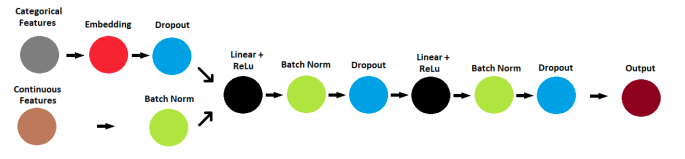

In [49]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class FeedForwardNN(nn.Module):

  def __init__(self, emb_dims, no_of_cont, lin_layer_sizes,
               output_size, emb_dropout, lin_layer_dropouts):

    """
    Parameters
    ----------

    emb_dims: List of two element tuples
      This list will contain a two element tuple for each
      categorical feature. The first element of a tuple will
      denote the number of unique values of the categorical
      feature. The second element will denote the embedding
      dimension to be used for that feature.

    no_of_cont: Integer
      The number of continuous features in the data.

    lin_layer_sizes: List of integers.
      The size of each linear layer. The length will be equal
      to the total number
      of linear layers in the network.

    output_size: Integer
      The size of the final output.

    emb_dropout: Float
      The dropout to be used after the embedding layers.

    lin_layer_dropouts: List of floats
      The dropouts to be used after each linear layer.
    """

    super().__init__()

    # Embedding layers
    self.emb_layers = nn.ModuleList([nn.Embedding(x, y)
                                     for x, y in emb_dims])

    no_of_embs = sum([y for x, y in emb_dims])
    self.no_of_embs = no_of_embs
    self.no_of_cont = no_of_cont

    # Linear Layers
    first_lin_layer = nn.Linear(self.no_of_embs + self.no_of_cont,
                                lin_layer_sizes[0])

    self.lin_layers =\
     nn.ModuleList([first_lin_layer] +\
          [nn.Linear(lin_layer_sizes[i], lin_layer_sizes[i + 1])
           for i in range(len(lin_layer_sizes) - 1)])
    
    for lin_layer in self.lin_layers:
      nn.init.kaiming_normal_(lin_layer.weight.data)

    # Output Layer
    self.output_layer = nn.Linear(lin_layer_sizes[-1],
                                  output_size)
    nn.init.kaiming_normal_(self.output_layer.weight.data)

    # Batch Norm Layers
    self.first_bn_layer = nn.BatchNorm1d(self.no_of_cont)
    self.bn_layers = nn.ModuleList([nn.BatchNorm1d(size)
                                    for size in lin_layer_sizes])

    # Dropout Layers
    self.emb_dropout_layer = nn.Dropout(emb_dropout)
    self.droput_layers = nn.ModuleList([nn.Dropout(size)
                                  for size in lin_layer_dropouts])

  def forward(self, cont_data, cat_data):

    if self.no_of_embs != 0:
      x = [emb_layer(cat_data[:, i])
           for i,emb_layer in enumerate(self.emb_layers)]
      x = torch.cat(x, 1)
      x = self.emb_dropout_layer(x)

    if self.no_of_cont != 0:
      normalized_cont_data = self.first_bn_layer(cont_data)

      if self.no_of_embs != 0:
        x = torch.cat([x, normalized_cont_data], 1) 
      else:
        x = normalized_cont_data

    for lin_layer, dropout_layer, bn_layer in\
        zip(self.lin_layers, self.droput_layers, self.bn_layers):
      
      x = F.relu(lin_layer(x))
      x = bn_layer(x)
      x = dropout_layer(x)

    x = self.output_layer(x)

    return x

In [ ]:
''' Example Neural Net for MovieLens dataset (Users, Movies)

lass EmbeddingNet(nn.Module):
    def __init__(self, n_users, n_movies, nh=10, p1=0.05, p2=0.5):
        super().__init__()
        (self.u, self.m) = [get_emb(*o) for o in [
            (n_users, n_factors), (n_movies, n_factors)]]
        self.lin1 = nn.Linear(n_factors*2, nh)
        self.lin2 = nn.Linear(nh, 1)
        self.drop1 = nn.Dropout(p1)
        self.drop2 = nn.Dropout(p2)
        
    def forward(self, cats, conts):
        users,movies = cats[:,0],cats[:,1]
        x = self.drop1(torch.cat([self.u(users),self.m(movies)], dim=1))
        x = self.drop2(F.relu(self.lin1(x)))
        return F.sigmoid(self.lin2(x)) * (max_rating-min_rating+1) + min_rating-0.5
'''

Now that we have created the basic data structure to run the training loop, we need to instantiate a model object of the FeedForwadNN class created earlier. This class requires a list of tuples, where each tuple represents a pair of total and the embedding dimension of a categorical variable

In [50]:
cat_dims = [int(df_small[col].nunique()) for col in categorical_features]
cat_dims

[4803, 71, 1609, 436]

In [51]:
emb_dims = [(x, min(50, (x + 1) // 2)) for x in cat_dims]
emb_dims

[(4803, 50), (71, 36), (1609, 50), (436, 50)]

 The hidden layer dimension is 50 and 100 for the first and second layers respectively. The embedding dropout used is 0.04. The hidden layer dropouts are 0.001 and 0.01. 

In [52]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#device = torch.device('cpu')
device

device(type='cpu')

In [83]:

model = FeedForwardNN(emb_dims, no_of_cont=len(dataset.cont_cols), 
                      lin_layer_sizes=[50, 100],
                      output_size=1, emb_dropout=0.04,
                      lin_layer_dropouts=[0.001,0.01])
model = model.to(device)

In [87]:
model.train()

FeedForwardNN(
  (emb_layers): ModuleList(
    (0): Embedding(4803, 50)
    (1): Embedding(71, 36)
    (2): Embedding(1609, 50)
    (3): Embedding(436, 50)
  )
  (lin_layers): ModuleList(
    (0): Linear(in_features=186, out_features=50, bias=True)
    (1): Linear(in_features=50, out_features=100, bias=True)
  )
  (output_layer): Linear(in_features=100, out_features=1, bias=True)
  (first_bn_layer): BatchNorm1d(0, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn_layers): ModuleList(
    (0): BatchNorm1d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (1): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (emb_dropout_layer): Dropout(p=0.04)
  (droput_layers): ModuleList(
    (0): Dropout(p=0.001)
    (1): Dropout(p=0.01)
  )
)

In [77]:
model.eval()

FeedForwardNN(
  (emb_layers): ModuleList(
    (0): Embedding(4803, 50)
    (1): Embedding(71, 36)
    (2): Embedding(1609, 50)
    (3): Embedding(436, 50)
  )
  (lin_layers): ModuleList(
    (0): Linear(in_features=186, out_features=50, bias=True)
    (1): Linear(in_features=50, out_features=100, bias=True)
  )
  (output_layer): Linear(in_features=100, out_features=1, bias=True)
  (first_bn_layer): BatchNorm1d(0, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn_layers): ModuleList(
    (0): BatchNorm1d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (1): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (emb_dropout_layer): Dropout(p=0.04)
  (droput_layers): ModuleList(
    (0): Dropout(p=0.001)
    (1): Dropout(p=0.01)
  )
)

 Run the training loop

In [55]:
categorical_features

['id', 'vote_average', 'vote_count', 'budget']

In [88]:
no_of_epochs = 5
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)

In [90]:
# state = {'epoch': epoch + 1,
#          'state_dict': model.state_dict(),
#          'optim_dict' : optimizer.state_dict()}

In [116]:
import os
import time

since = time.time()

best_model_wts = copy.deepcopy(model.state_dict())
best_acc = 0.0

for epoch in range(no_of_epochs):
    running_loss = 0.0
    i=0
    print('Epoch {}/{}'.format(epoch, no_of_epochs - 1))
    model.train()
    pid = os.getpid()
    for y, cont_x, cat_x in dataloader:
        i += 1
        cat_x = cat_x.to(device)
        cont_x = cont_x.to(device)
        y  = y.to(device)

        # Forward Pass
        preds = model(cont_x, cat_x)
        loss = criterion(preds, y)
        
        # Backward Pass and Optimization
        
        # zero the parameter gradients
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # print statistics
        if batch_idx % 1000:    # print every n mini-batches         
            print('{}\tTrain Epoch: {} [{}/{} ({:.0f}%)] Loss: {:.4f}'.format(
                pid, epoch, i * len(cat_x), len(dataloader.dataset),
                100. * i / len(dataloader), loss.item()))


Epoch 0/4
11890	Train Epoch: 0 [64/4803 (1%)] Loss: 71.4264
11890	Train Epoch: 0 [128/4803 (3%)] Loss: 86.3414
11890	Train Epoch: 0 [192/4803 (4%)] Loss: 85.2336
11890	Train Epoch: 0 [256/4803 (5%)] Loss: 65.9389
11890	Train Epoch: 0 [320/4803 (7%)] Loss: 72.7590
11890	Train Epoch: 0 [384/4803 (8%)] Loss: 44.6330
11890	Train Epoch: 0 [448/4803 (9%)] Loss: 45.0564
11890	Train Epoch: 0 [512/4803 (11%)] Loss: 52.8659
11890	Train Epoch: 0 [576/4803 (12%)] Loss: 82.5601
11890	Train Epoch: 0 [640/4803 (13%)] Loss: 85.0812
11890	Train Epoch: 0 [704/4803 (14%)] Loss: 18.3583
11890	Train Epoch: 0 [768/4803 (16%)] Loss: 25.2109
11890	Train Epoch: 0 [832/4803 (17%)] Loss: 11.4357
11890	Train Epoch: 0 [896/4803 (18%)] Loss: 32.8379
11890	Train Epoch: 0 [960/4803 (20%)] Loss: 18.2873
11890	Train Epoch: 0 [1024/4803 (21%)] Loss: 20.8141
11890	Train Epoch: 0 [1088/4803 (22%)] Loss: 26.5773
11890	Train Epoch: 0 [1152/4803 (24%)] Loss: 62.1367
11890	Train Epoch: 0 [1216/4803 (25%)] Loss: 53.6979
11890	

11890	Train Epoch: 2 [448/4803 (9%)] Loss: 70.6455
11890	Train Epoch: 2 [512/4803 (11%)] Loss: 92.7028
11890	Train Epoch: 2 [576/4803 (12%)] Loss: 33.2742
11890	Train Epoch: 2 [640/4803 (13%)] Loss: 14.4710
11890	Train Epoch: 2 [704/4803 (14%)] Loss: 37.7060
11890	Train Epoch: 2 [768/4803 (16%)] Loss: 60.9734
11890	Train Epoch: 2 [832/4803 (17%)] Loss: 50.3358
11890	Train Epoch: 2 [896/4803 (18%)] Loss: 63.3250
11890	Train Epoch: 2 [960/4803 (20%)] Loss: 29.6606
11890	Train Epoch: 2 [1024/4803 (21%)] Loss: 34.0828
11890	Train Epoch: 2 [1088/4803 (22%)] Loss: 80.1624
11890	Train Epoch: 2 [1152/4803 (24%)] Loss: 29.1075
11890	Train Epoch: 2 [1216/4803 (25%)] Loss: 61.3146
11890	Train Epoch: 2 [1280/4803 (26%)] Loss: 253.4844
11890	Train Epoch: 2 [1344/4803 (28%)] Loss: 20.7052
11890	Train Epoch: 2 [1408/4803 (29%)] Loss: 26.8652
11890	Train Epoch: 2 [1472/4803 (30%)] Loss: 27.8714
11890	Train Epoch: 2 [1536/4803 (32%)] Loss: 491.3324
11890	Train Epoch: 2 [1600/4803 (33%)] Loss: 15.3487
1

11890	Train Epoch: 4 [1152/4803 (24%)] Loss: 30.7482
11890	Train Epoch: 4 [1216/4803 (25%)] Loss: 66.1544
11890	Train Epoch: 4 [1280/4803 (26%)] Loss: 76.7691
11890	Train Epoch: 4 [1344/4803 (28%)] Loss: 30.4178
11890	Train Epoch: 4 [1408/4803 (29%)] Loss: 52.8545
11890	Train Epoch: 4 [1472/4803 (30%)] Loss: 35.4744
11890	Train Epoch: 4 [1536/4803 (32%)] Loss: 37.5171
11890	Train Epoch: 4 [1600/4803 (33%)] Loss: 27.8156
11890	Train Epoch: 4 [1664/4803 (34%)] Loss: 116.3395
11890	Train Epoch: 4 [1728/4803 (36%)] Loss: 20.6888
11890	Train Epoch: 4 [1792/4803 (37%)] Loss: 60.8789
11890	Train Epoch: 4 [1856/4803 (38%)] Loss: 43.7304
11890	Train Epoch: 4 [1920/4803 (39%)] Loss: 23.7918
11890	Train Epoch: 4 [1984/4803 (41%)] Loss: 21.0457
11890	Train Epoch: 4 [2048/4803 (42%)] Loss: 22.7369
11890	Train Epoch: 4 [2112/4803 (43%)] Loss: 393.9542
11890	Train Epoch: 4 [2176/4803 (45%)] Loss: 51.3721
11890	Train Epoch: 4 [2240/4803 (46%)] Loss: 91.8206
11890	Train Epoch: 4 [2304/4803 (47%)] Loss: